# Using the `xtractomatic` R package to track Pacific Blue Marlin

The `xtractomatic` package can be used to subset data from remote servers. From the [GitHub README](https://github.com/rmendels/xtractomatic):

    xtractomatic is an R package developed to subset and extract satellite and other oceanographic related data from a remote server. The program can extract data for a moving point in time along a user-supplied set of longitude, latitude and time points; in a 3D bounding box; or within a polygon (through time). The xtractomatic functions were originally developed for the marine biology tagging community, to match up environmental data available from satellites (sea-surface temperature, sea-surface chlorophyll, sea-surface height, sea-surface salinity, vector winds) to track data from various tagged animals or shiptracks

There are routines to extract data from a `lon`, `lat`, `time` track (like a drifter or glider trajectory), a 3D bounding box, or within a polygon. For this example let us use the built-in dataset for the tagged blue marlin fish in the Pacific Ocean (`Marlintag38606`).

In [1]:
library('xtractomatic')

str(Marlintag38606)

'data.frame':	152 obs. of  7 variables:
 $ date  : Date, format: "2003-04-23" "2003-04-24" ...
 $ lon   : num  204 204 204 204 204 ...
 $ lat   : num  19.7 19.8 20.4 20.3 20.3 ...
 $ lowLon: num  204 204 204 204 204 ...
 $ higLon: num  204 204 204 204 204 ...
 $ lowLat: num  19.7 18.8 18.8 18.9 18.9 ...
 $ higLat: num  19.7 20.9 21.9 21.7 21.7 ...


This is a "track-like" data set of the tagged marlin with `lon`, `lat`, `time` arrays.

In [2]:
tagData <- Marlintag38606
xpos <- tagData$lon
ypos <- tagData$lat
tpos <- tagData$date

Now we can extract, for example, SeaWiFS chlorophyll 8 day composite(`swchla8day`) data around the recorded tags to see if the marlin follow areas of high productivity to presumably find food.

Note the that `xlen=0.2` and `ylen=0.2` is the bounding latitude/longitude box (in decimal degrees) for finding the data around the desired positions

In [3]:
swchl <- xtracto("swchla8day", xpos, ypos, tpos = tpos, , xlen = .2, ylen = .2)

In [4]:
str(swchl)

'data.frame':	152 obs. of  11 variables:
 $ mean chlorophyll  : num  0.073 NaN 0.074 0.0653 0.0403 ...
 $ stdev chlorophyll : num  NA NA 0.00709 0.00768 0.02278 ...
 $ n                 : int  1 0 16 4 7 9 4 3 0 6 ...
 $ satellite date    : chr  "2003-04-19" "2003-04-27" "2003-04-27" "2003-04-27" ...
 $ requested lon min : num  204 204 204 204 204 ...
 $ requested lon max : num  204 204 204 204 204 ...
 $ requested lat min : num  19.6 19.7 20.3 20.2 20.2 ...
 $ requested lat max : num  19.8 19.9 20.5 20.4 20.4 ...
 $ requested date    : num  12165 12166 12172 12173 12174 ...
 $ median chlorophyll: num  0.073 NA 0.073 0.0645 0.031 ...
 $ mad chlorophyll   : num  0 NA 0.00297 0.00741 0.0089 ...


Now we can use the `maps` and `ggplot2` packages to plot the results.

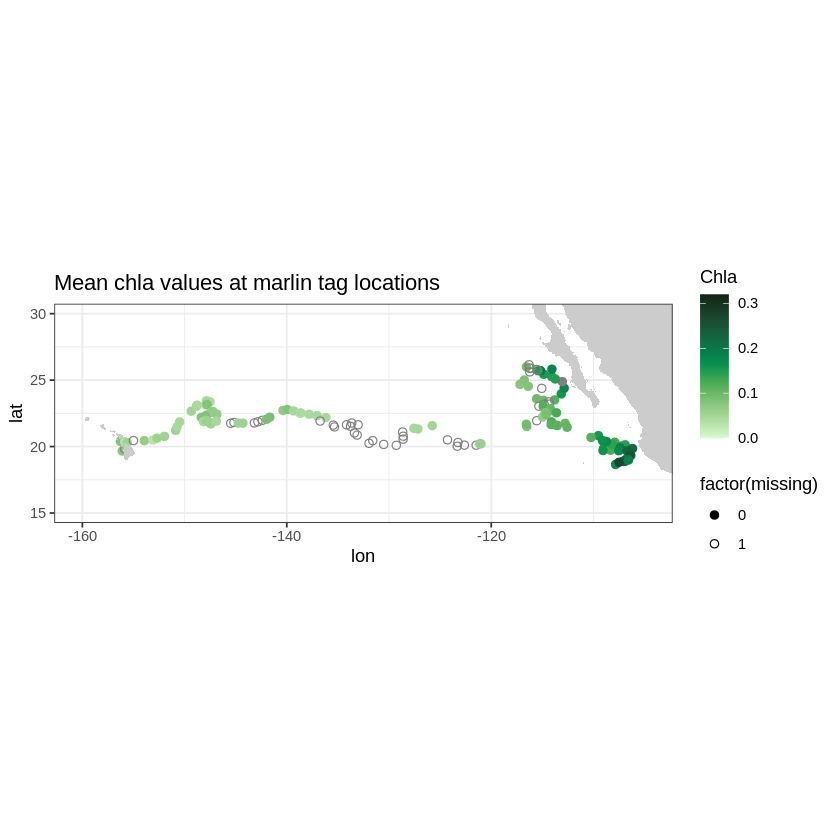

In [5]:
library('ggplot2')
library('maps')
library('mapdata')

alldata <- cbind(swchl, tagData)
alldata$lon <- alldata$lon - 360
alldata$missing <- is.na(alldata$mean) * 1
colnames(alldata)[1] <- 'mean'

# set limits of the map
ylim <- c(15, 30)
xlim <- c(-160, -105)

# get outline data for map
w <- map_data("worldHires", ylim = ylim, xlim = xlim)

# plot using ggplot
myColor <- colors$algae
z <- ggplot(alldata,aes(x = lon, y = lat)) + 
   geom_point(aes(colour = mean, shape = factor(missing)), size = 2.) + 
   scale_shape_manual(values = c(19, 1))
z + geom_polygon(data = w, aes(x = long, y = lat, group = group), fill = "grey80") + 
  theme_bw() + 
  scale_colour_gradientn(colours = myColor, limits = c(0., 0.32), "Chla") + 
  coord_fixed(1.3, xlim = xlim, ylim = ylim) + ggtitle("Mean chla values at marlin tag locations")

We can do the same for topography data. Let's use the `ETOPO360` dataset to display the depth at the tag locations.

In [6]:
ylim <- c(15, 30)
xlim <- c(-160, -105)
topo <- xtracto("ETOPO180", tagData$lon, tagData$lat, xlen = .1, ylen = .1)

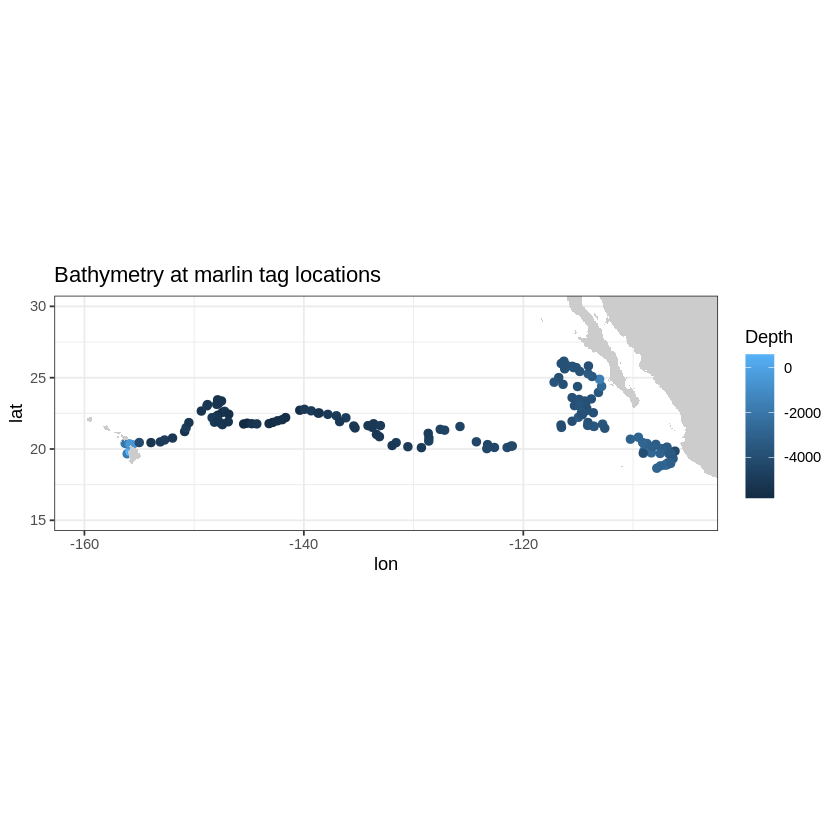

In [7]:
alldata <- cbind(topo, tagData)
alldata$lon <- alldata$lon - 360
colnames(alldata)[1] <- 'mean'
z <- ggplot(alldata, aes(x = lon,y = lat)) + 
   geom_point(aes(colour = mean), size = 2.) + 
  scale_shape_manual(values = c(19, 1))
z + geom_polygon(data = w, aes(x = long, y = lat, group = group), fill = "grey80") + 
  theme_bw() + 
  scale_colour_gradient("Depth") + 
  coord_fixed(1.3, xlim = xlim, ylim = ylim) + ggtitle("Bathymetry at marlin tag locations")

For more information and example on the other routines see the full example from the documentation at [https://rmendels.github.io/Usingxtractomatic_3.4.0.nb.html](https://rmendels.github.io/Usingxtractomatic_3.4.0.nb.html)


PS: note that R and all the `xtractomatic` dependencies are already included in the [IOOS conda environment](http://ioos.github.io/notebooks_demos/other_resources/).